In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
x, y = mnist['data'], mnist['target']

In [5]:
x.shape, y.shape

((70000, 784), (70000,))

In [6]:
y = y.astype(np.uint8) # Targets are represented as strings, so we need to convert them into digits.
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

## Visualize image

In [7]:
random_image = x[0]
random_image_2d = random_image.reshape(28, 28)

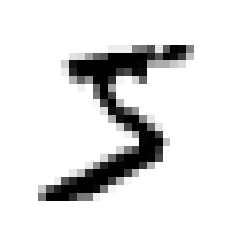

In [8]:
plt.imshow(random_image_2d, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

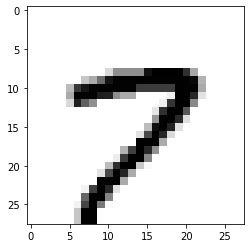

In [9]:
plt.imshow(x[123].reshape(28,28), cmap=mpl.cm.binary)

In [10]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## One-digit detector (binary detector)

In [11]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [12]:
model = SGDClassifier(random_state=42)
model.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
model.predict([x_train[0]])

array([ True])

## Validation

In [14]:
cross_val_score(model, x_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This is pretty high accuracy, but we cannot be below 0.9 because we have only 10% images with five digit.

### Confusion Matrix

In [15]:
predicts = cross_val_predict(model, x_train, y_train_5, cv=3) # Clean prediction - the prediction is made by a model that never saw the data during training.
predicts

array([ True, False, False, ...,  True, False, False])

In [16]:
confusion_matrix(y_train_5, predicts) ## [TRUE Negative, False Positive],[False Negative, True Positive]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
confusion_matrix(y_train_5, y_train_5) # Perfect predictions

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision/Recall Tradeoff

In [18]:
precision_score(y_train_5, predicts), recall_score(y_train_5, predicts), f1_score(y_train_5, predicts)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

In [19]:
predict_scores = cross_val_predict(model, x_train, y_train_5, cv=3, method='decision_function')
predict_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [20]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, predict_scores)
precisions, recalls, thresholds

(array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.80)]
recall_90_precision = recalls[np.argmax(precisions >= 0.80)]

y_train_pred_90 = (predict_scores >= threshold_90_precision)

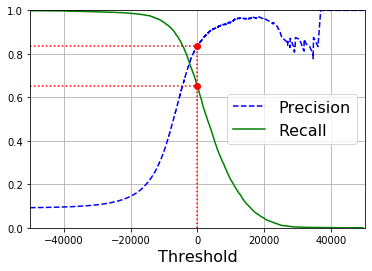

In [22]:
def plot_precision_recall_vs_threshold_by_precision(precisions, recalls, thresholds, precision):
    threshold_90_precision = thresholds[np.argmax(precisions >= precision)]
    recall_90_precision = recalls[np.argmax(precisions >= precision)]
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    plt.plot([threshold_90_precision, threshold_90_precision], [0., precision], "r:")
    plt.plot([-50000, threshold_90_precision], [precision, precision], "r:")
    plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([threshold_90_precision], [precision], "ro")
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")
    plt.show()
    
plot_precision_recall_vs_threshold_by_precision(precisions, recalls, thresholds, 0.8370879772350012)

In [23]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)
#If someone says “let’s reach 99% precision,” you should ask, “atwhat recall?”

(0.8, 0.7127836192584394)

### Changing threshold

In [24]:
threshold_at_precision = thresholds[np.argmax(precisions >= 0.95)] # Find threshold for specific precision
threshold_at_precision

10480.508645329957

In [25]:
predicts_at_precision = (predict_scores >= threshold_at_precision)
predicts_at_precision

array([False, False, False, ...,  True, False, False])

In [26]:
precision_score(y_train_5, predicts_at_precision), recall_score(y_train_5, predicts_at_precision), f1_score(y_train_5, predicts_at_precision)

(0.9503367003367004, 0.20826415790444566, 0.34165531850506886)

### ROC Curve

In [27]:
fpr, tpr, thresholds = roc_curve(y_train_5, predict_scores)

In [28]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  49442.43765905,   49441.43765905,   36801.60697028, ...,
        -105763.22240074, -106527.45300471, -146348.56726174]))

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal

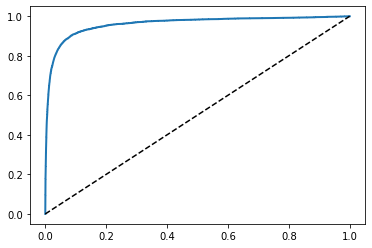

In [30]:
plot_roc_curve(fpr, tpr)

In [31]:
roc_auc_score(y_train_5, predict_scores)

0.9604938554008616

In [32]:
forest_clf = RandomForestClassifier(random_state=42)

In [33]:
forest_probas = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
forest_scores = forest_probas[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, forest_scores)

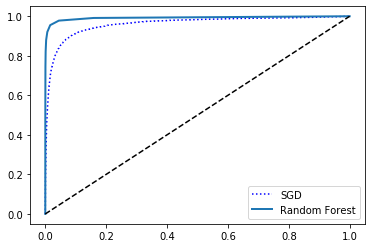

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [36]:
roc_auc_score(y_train_5, forest_scores)

0.9920527492698306

In [37]:
forest_predicts = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
precision_score(y_train_5, forest_predicts), recall_score(y_train_5, forest_predicts)

(0.986046511627907, 0.8212506917542889)

## Multiclass Classification

Strategies: **OneVsOneClassifier OneVsRestClassifier**. Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. Random Forest classifiers or naive Bayes classifiers are capable of handling multiple classes directly.

### TODO: Compare SGD Classifier with Random Forest Clasifier

In [50]:
m_sgd_classifier = SGDClassifier(random_state=42)
cross_val_score(m_sgd_classifier, x_train, y_train, cv = 3, scoring='accuracy')

KeyboardInterrupt: 

In [40]:
m_forest_classifier = RandomForestClassifier()
cross_val_score(m_forest_classifier, x_train, y_train, cv=3, scoring='accuracy')

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.94011198, 0.93879694, 0.9433415 ])

In [43]:
m_forest_predicts = cross_val_predict(m_forest_classifier, x_train, y_train, cv=3)

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
conf_mx = confusion_matrix(y_train, m_forest_predicts)
conf_mx

array([[5801,    1,   24,    7,   10,   15,   19,    5,   35,    6],
       [   1, 6621,   34,   20,   11,    8,    7,   15,   16,    9],
       [  58,   25, 5614,   57,   41,   18,   24,   50,   54,   17],
       [  20,   23,  150, 5623,    7,  127,   20,   44,   75,   42],
       [  18,   27,   29,    7, 5526,    9,   36,   20,   27,  143],
       [  45,   11,   27,  210,   31, 4941,   57,    8,   54,   37],
       [  53,   18,   30,    9,   21,   83, 5685,    1,   16,    2],
       [  11,   31,  104,   20,   69,    9,    2, 5920,   21,   78],
       [  37,   59,  109,  135,   60,   96,   44,   19, 5215,   77],
       [  33,   15,   20,   83,  177,   43,   11,   94,   69, 5404]],
      dtype=int64)

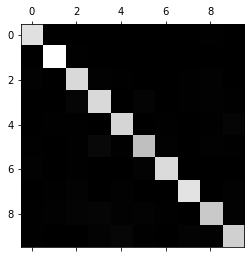

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

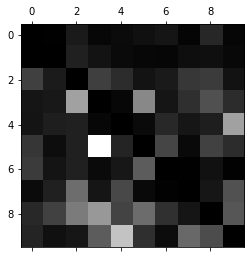

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [56]:
index = 7
y_train[index], knn_clf.predict([x_train[index]])

(3, array([[False,  True]]))

In [ ]:
knn_predicts = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_multilabel, knn_predicts, average="macro")